# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, March 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1WBmo1Lz5bZYxZdVpK0UQwQUkX-oBpe4s

In [0]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt


## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [0]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [189]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [190]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [191]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [192]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [193]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [194]:
sum(df["sex"] == " Male")/32561

0.6692054912318418

In [195]:
sum(df["sex"] == " Female")/32561

0.33079450876815825

### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [0]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [0]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [198]:
df_not_missing.work.unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [0]:
data = pd.get_dummies(df_not_missing)

In [200]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,39,13,2174,0,40,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,38,9,0,0,40,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [201]:
print("The dataframe data contains {} columns.".format(len(data.columns)))

The dataframe data contains 57 columns.


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [0]:
datanp = data.values.astype(np.float32)

In [0]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.

    ind = np.argmax(onehot)
    values = cat_values[feature]
    return values[ind]


In [0]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [0]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

train_index = int(datanp.shape[0] * 0.7)
val_index = int(datanp.shape[0] * 0.85)

train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]

In [206]:
print("# Train Set: " + str(train_set.shape[0]))
print("# Test Set: " + str(val_set.shape[0]))
print("# Val Set: " + str(test_set.shape[0]))

# Train Set: 21502
# Test Set: 4608
# Val Set: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [0]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 34), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(34, 25),
            nn.Linear(25, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 25), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(25, 34),
            nn.Linear(34, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The input values are all within the range of 0 to 1. As such, since the decoder needs to reconstruct the inputs, the output of the decoder should also be within the range of 0 to 1. The sigmoid activation guarantees that the final output of the decoder will be in that range.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [0]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    

    for epoch in range(num_epochs):
        total_loss = 0
        i = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature

            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            i += 1
        
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)
        train_loss[epoch] = total_loss/(i + 1)
        val_loss[epoch] = get_loss(model, valid_loader, criterion)

        print("epoch: ", epoch, end = " ")
        print("train acc: ", train_acc[epoch], end = " ")
        print("val acc: ", val_acc[epoch])

    epochs = np.arange(1, num_epochs + 1)
    
    return train_acc, val_acc, train_loss, val_loss, epochs

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [0]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

def get_loss(model, data_loader, criterion):
  tot_loss = 0
  i = 0
  for data in data_loader:
    datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
    recon = model(datam)
    loss = criterion(recon, data)
    tot_loss += loss.item()
    i += 1

  return tot_loss/(i + 1)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch:  0 train acc:  0.28613617337922054 val acc:  0.28718171296296297
epoch:  1 train acc:  0.40038135987350015 val acc:  0.4014756944444444
epoch:  2 train acc:  0.41584503767091435 val acc:  0.4168836805555556
epoch:  3 train acc:  0.4216119430750628 val acc:  0.42259837962962965
epoch:  4 train acc:  0.4218909868849409 val acc:  0.42277922453703703
epoch:  5 train acc:  0.4305180913403404 val acc:  0.4308449074074074
epoch:  6 train acc:  0.430975413139863 val acc:  0.43135127314814814
epoch:  7 train acc:  0.43186680308808484 val acc:  0.4322916666666667
epoch:  8 train acc:  0.43332403187300406 val acc:  0.4342086226851852
epoch:  9 train acc:  0.43868012277927637 val acc:  0.4390552662037037
epoch:  10 train acc:  0.45162465507084615 val acc:  0.45102719907407407
epoch:  11 train acc:  0.4595463987846092 val acc:  0.4577907986111111
epoch:  12 train acc:  0.4645381824946517 val acc:  0.462890625
epoch:  13 train acc:  0.4685378104362385 val acc:  0.46726707175925924
epoch:  14 

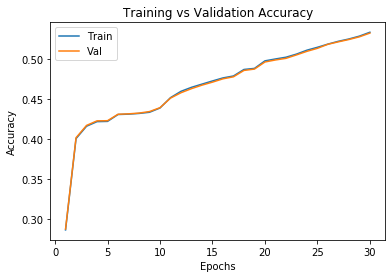

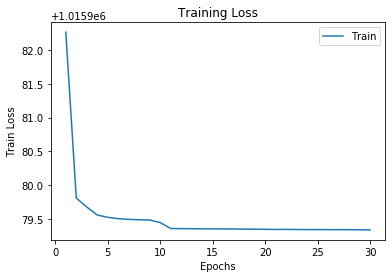

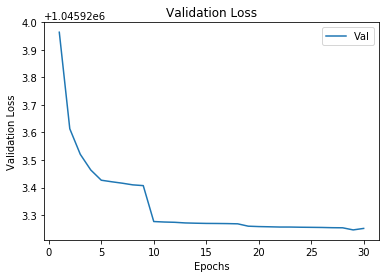

In [211]:
# Default/Initial Parameters

batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder1 = AutoEncoder()

train_acc, val_acc, train_loss, val_loss, epochs = train(autoencoder1, train_loader, valid_loader, num_epochs=30, learning_rate=1e-4)

plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Training Loss")
plt.plot(epochs, train_loss, label="Train")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

plt.title("Validation Loss")
plt.plot(epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend(loc='best')
plt.show()


### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [0]:
# First Try Parameters - BS: 64, Epochs: 30, LR: 1e-4
# Results - train acc:  0.5794732272966856, val acc:  0.5802228009259259
# Accuracy hadn't yet reached a plateau so I decided to increase the number of epochs

# Second Try Parameters - BS: 64, Epochs: 50, LR: 1e-4
# Results - train acc:  0.5933013983195362, val acc:  0.5933883101851852
# Very little improvement so it appeared like overfitting. I decided to try and play with batch size instead.

# Third Try Parameters - BS: 512, Epochs: 30, LR: 1e-4
# Results - train acc:  0.44347812606579234, val acc:  0.4425636574074074
# Performance decreased, so I tried to heavily decrease the batch size.

# Fourth Try Parameters - BS: 32, Epochs: 30, LR: 1e-4
# Results - train acc:  0.5802948562924379, val acc:  0.5813078703703703
# Performance improved but it wasn't notably better than the original try, so I just went back to batch size 64 and tried to increase LR a little

#5. BS: 64, Epochs: 30, LR: 5e-4, epoch:  29 train acc:  0.59523145133786 val acc:  0.5895543981481481
# a little bit better than other models that weren't heavily overfitted, so I decided to use it.


epoch:  0 train acc:  0.4608408520137662 val acc:  0.45808015046296297
epoch:  1 train acc:  0.4517254208910799 val acc:  0.45102719907407407
epoch:  2 train acc:  0.4621508076768053 val acc:  0.46187789351851855
epoch:  3 train acc:  0.49074504697237464 val acc:  0.4906684027777778
epoch:  4 train acc:  0.5351130127430006 val acc:  0.5380497685185185
epoch:  5 train acc:  0.5574287663163117 val acc:  0.5583043981481481
epoch:  6 train acc:  0.5638002666418628 val acc:  0.5662254050925926
epoch:  7 train acc:  0.5719390444299755 val acc:  0.5748697916666666
epoch:  8 train acc:  0.5765975258115524 val acc:  0.5766420717592593
epoch:  9 train acc:  0.5624825597618827 val acc:  0.5645254629629629
epoch:  10 train acc:  0.5734892878181874 val acc:  0.5748697916666666
epoch:  11 train acc:  0.5727684246426689 val acc:  0.5734592013888888
epoch:  12 train acc:  0.581736582643475 val acc:  0.5819950810185185
epoch:  13 train acc:  0.578225281369175 val acc:  0.5787037037037037
epoch:  14 tra

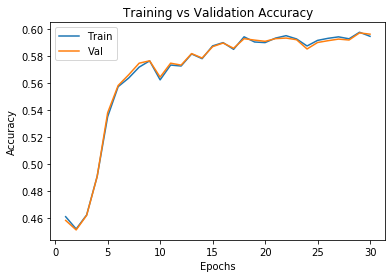

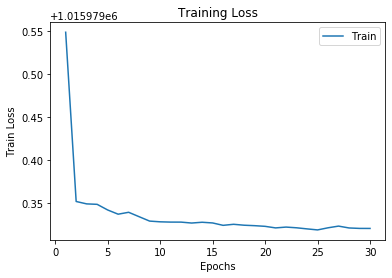

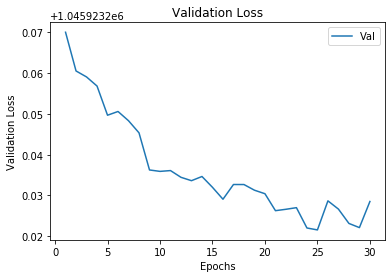

In [212]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder5 = AutoEncoder()

train_acc, val_acc, train_loss, val_loss, epochs = train(autoencoder5, train_loader, valid_loader, num_epochs=30, learning_rate=5e-4)

plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Training Loss")
plt.plot(epochs, train_loss, label="Train")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

plt.title("Validation Loss")
plt.plot(epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend(loc='best')
plt.show()


## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

The test accuracy of my final autoencoder model was just under 59%.

In [213]:
print(get_accuracy(autoencoder5, test_loader))

0.5885416666666666


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [214]:
colModes = {}
for col in catcols:
  colModes[col] = df.mode()[col].item()


  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
def baseline_model(vec):
  for col in catcols:
    if (np.sum(get_onehot(vec, col)) == 0):
      mode = str(colModes[col]).strip()
      pred = np.zeros(len(cat_values[col]))
      pred[cat_values[col].index(mode)] = 1

      for i in range(len(pred)):
        vec[cat_index[col] + i] = pred[i]
  return vec

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your baseline test accuracy in part (b)?

In [0]:
def get_accuracy_baseline(data_set):
    total = 0
    acc = 0
    for col in catcols:
      for row in data_set:
        row_mod = zero_out_feature_mod(np.copy(row), col)
        prediction = baseline_model(row_mod)
        for i in range(prediction.shape[0]): # record in minibatch
          acc += int(get_feature(prediction, col) == get_feature(row, col))
          total += 1
    
    return acc/total

def zero_out_feature_mod(record, feature):
    """ Set the feature missing in record, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    for i in range(stop_index - start_index):
      record[start_index + i] = 0
    return record

In [217]:
get_accuracy_baseline(test_set)

0.4568504050925926

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [218]:
for col in catcols:
  print(col + ": " + get_categorical_value(get_onehot(test_set[0], col), col))

work: Private
marriage: Divorced
occupation: Prof-specialty
edu: Bachelors
relationship: Not-in-family
sex: Male


No, I don't think it's reasonable for a person to guess this education level based on the other features since most people would immediately assume a Professor has a PhD degree.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [219]:
test_input = torch.from_numpy(zero_out_feature_mod(test_set[0], "edu"))

pred = autoencoder5(test_input)

result = pred.detach().numpy()

for col in catcols:
  print(col + ": " + get_categorical_value(get_onehot(result, col), col))

work: Private
marriage: Married-civ-spouse
occupation: Craft-repair
edu: Bachelors
relationship: Husband
sex: Male


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [220]:
test_input = zero_out_feature_mod(test_set[0], "edu")

baseline_pred = baseline_model(test_input)

for col in catcols:
  print(col + ": " + get_categorical_value(get_onehot(baseline_pred, col), col))

work: Private
marriage: Divorced
occupation: Prof-specialty
edu: HS-grad
relationship: Not-in-family
sex: Male


The baseline model predicts that the person has an education level of having graduated high school. This is because high school graduation is the most common value for education in the training set.